In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from load_dataset import load_labelling_data, load_LDT_dataset, LDT_save_all
from data_preprocessing import feature_selection, MyPCA
from models import ANNModel, AdaBoost
from sklearn.metrics import roc_curve,auc
from scipy.stats import zscore
%matplotlib inline

In [25]:
signals = load_labelling_data("../dataset/signals.csv", "../dataset/logs.csv")

D:\Anaconda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
D:\Anaconda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [26]:
signals = signals.iloc[:,3:]
signals = signals.drop(['Prod_LatestAvg_ActPwrGen2','Prod_LatestAvg_ReactPwrGen2'], axis = 1)

In [27]:
# signals = feature_selection(signals)
signals = signals[['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 
         'Gen_Bear_Temp_Avg',
         'Gear_Bear_Temp_Avg', 
         'Nac_Temp_Avg', 
         'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Rtr_RPM_Std',
         'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 
         'Amb_Temp_Avg',
         'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr',
         'Cont_Hub_Temp_Avg', 
         'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg','Blds_PitchAngle_Std',
         'Grd_Prod_Freq_Avg', 
         'Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse2_Avg', 'Grd_Prod_VoltPhse3_Avg',
         'Grd_Prod_Pwr_Max', 'Grd_Prod_Pwr_Min', 'Grd_Prod_ReactPwr_Avg', 'Grd_Prod_ReactPwr_Max', 'Grd_Prod_ReactPwr_Min', 'Grd_Prod_ReactPwr_Std',
         'Nac_Direction_Avg',
         'isFaulty']]


labels = signals["isFaulty"]
cols = signals.drop(["isFaulty"], axis=1).columns
features_norm = zscore(signals.drop(["isFaulty"], axis=1))
features_norm = pd.DataFrame(features_norm, columns=cols)
signals_norm = pd.concat([features_norm, labels], axis=1) 
signals = signals_norm.dropna()

signals_test = signals.sample(frac = 0.2, random_state = 24)
signals_train = signals.drop(signals_test.index, axis = 0)

Y_train = signals_train['isFaulty']
X_train = signals_train.drop(["isFaulty"], axis=1)

In [2]:
'''
# LDT_save_all()

LDT_data = pd.read_csv("LDT_total_data.csv")
LDT_data = LDT_data.iloc[:,1:]


#normalization
labels = LDT_data["isFaulty"]
cols = LDT_data.drop(["isFaulty"], axis=1).columns
features_norm = zscore(LDT_data.drop(["isFaulty"], axis=1))
features_norm = pd.DataFrame(features_norm, columns=cols)
signals_norm = pd.concat([features_norm, labels], axis=1) 
LDT_data = signals_norm.dropna()

#split
signals_test = LDT_data.sample(frac = 0.2, random_state = 24)
signals_train = LDT_data.drop(signals_test.index, axis = 0)

Y_train = signals_train['isFaulty']
X_train = signals_train.drop(["isFaulty"], axis=1)
'''

Counter({0: 509, 1: 509})
-------------------------------------------
[INFO] no of neurons: 60
[INFO] training model...
Epoch 1/50
26/26 [==============================] - 0s 539us/step - loss: 0.6303 - accuracy: 0.6290
Epoch 2/50
26/26 [==============================] - 0s 539us/step - loss: 0.4067 - accuracy: 0.7985
Epoch 3/50
26/26 [==============================] - 0s 539us/step - loss: 0.3178 - accuracy: 0.8686
Epoch 4/50
26/26 [==============================] - 0s 539us/step - loss: 0.2961 - accuracy: 0.9005
Epoch 5/50
26/26 [==============================] - 0s 500us/step - loss: 0.2649 - accuracy: 0.9066
Epoch 6/50
26/26 [==============================] - 0s 462us/step - loss: 0.2483 - accuracy: 0.9115
Epoch 7/50
26/26 [==============================] - 0s 539us/step - loss: 0.2287 - accuracy: 0.9251
Epoch 8/50
26/26 [==============================] - 0s 539us/step - loss: 0.2025 - accuracy: 0.9263
Epoch 9/50
26/26 [==============================] - 0s 500us/step - loss: 0.1979

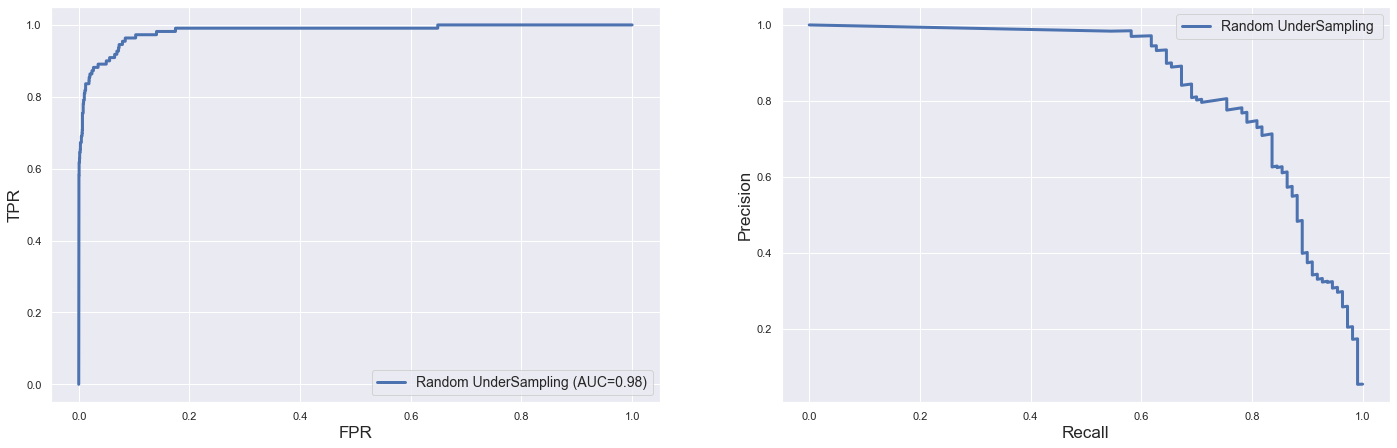

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
from models import ANNModel
from data_preprocessing import feature_selection, zscore_norm
import time

sampling_methods = [
    "None",
    RandomUnderSampler(sampling_strategy='majority'),
    SMOTE(random_state=24),
    SMOTEENN(random_state=24)
]

names = [
    "Base Model",
    "Random UnderSampling",
    "SMOTE",
    "SMOTE+ENN"
]

plt.figure(figsize=(24,16))

for (name, method) in zip(names, sampling_methods):
    if method == "None":
        X, Y = X_train, Y_train
    else:
        X, Y = method.fit_sample(X_train, Y_train)
    
#     X = feature_selection(X)
 
    print(Counter(Y))
    
    X_test = signals_test.loc[:,X.columns]
    Y_test = signals_test["isFaulty"]
    
    model = ANNModel(X, Y)
#     model = AdaBoost(X, Y)    

    y_prob = model.predict(X_test)    
    y_pred = tf.round(y_prob)
#     y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_prob, pos_label=1)
    plt.subplot(221)
    plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.2f})'.
             format(name, auc(fpr, tpr)))
    plt.xlabel("FPR", fontsize=17)
    plt.ylabel("TPR", fontsize=17)
    plt.legend(fontsize=14)

    class_names = ['not Faulty', 'Faulty']
    print("------------------------" + name + "---------------------- \n", 
      classification_report(Y_test, y_pred, target_names=class_names), '\n')
    
    precision, recall, thresholds = precision_recall_curve(Y_test, y_prob, pos_label=1)
    plt.subplot(222)
    plt.plot(recall, precision, lw=3, label='{} '.
             format(name))
    plt.xlabel("Recall", fontsize=17)
    plt.ylabel("Precision", fontsize=17)
    plt.legend(fontsize=14, loc="best")

In [36]:
ldt_test = load_LDT_dataset(1)
Y_test_LDT = ldt_test['isFaulty']
X_test_LDT = ldt_test.drop('isFaulty', axis = 1)

X_test_LDT = zscore(X_test_LDT)

In [37]:
reconstructed_model = keras.models.load_model("myANNModel")
reconstructed_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 60)                2100      
_________________________________________________________________
dropout_23 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 61        
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [38]:
y_pred = reconstructed_model.predict(X_test_LDT).flatten()

In [39]:
import utils
prec = utils.metric_precision(Y_test_LDT, y_pred)
print('prec:{}%'.format(prec*100))
recall = utils.metric_recall(Y_test_LDT, y_pred)
print('recall:{}%'.format(recall*100))
f1 = utils.metric_F1score(Y_test_LDT, y_pred)
print('f1score:{}'.format(f1))

prec:35.02824783325195%
recall:89.85507202148438%
f1score:0.5040650367736816


In [40]:
TP = tf.reduce_sum(Y_test_LDT * tf.round(y_pred))
TN = tf.reduce_sum((1 - Y_test_LDT) * (1 - tf.round(y_pred)))
FP = tf.reduce_sum((1 - Y_test_LDT) * tf.round(y_pred))
FN = tf.reduce_sum(Y_test_LDT * (1 - tf.round(y_pred)))
TP, TN, FP, FN

(<tf.Tensor: shape=(), dtype=float32, numpy=124.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3070.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=230.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=14.0>)

In [41]:
(TP + TN) / (FP+FN+TP+TN)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9290285>

[[3070  230]
 [  14  124]]


Text(21.5, 0.5, 'True Label')

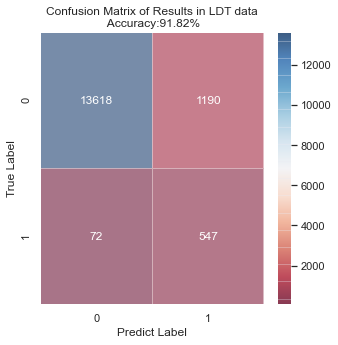

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots( figsize=(5,5))
C2= confusion_matrix(Y_test_LDT, y_pred.round(), labels=[0, 1])
print(C2)

C2=[[13618, 1190],
    [72, 547]]

sns.heatmap(C2, annot=True, ax=ax, cmap='RdBu', fmt='.20g', linewidths = 0.05, alpha=0.5) 

ax.set_title('Confusion Matrix of Results in LDT data\n Accuracy:91.82%') 
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')